TODO: `search_recent_tweets` is up to 7 days. To search further back, use [search_all_tweets](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets) instead (and add `start_time` parameter). But it needs the [academic research access](https://developer.twitter.com/en/docs/projects). It also increases the monthly cap from 500,000 to 10 million, `max_results` from 100 to 500, and allows to use `-is:nullcast ` to filter out some ads.

In [1]:
from datetime import datetime, timezone, timedelta
from collections import defaultdict
from time import time
import json
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tweepy

In [2]:
#TODO tune
bearer_token = "AAAAAAAAAAAAAAAAAAAAAH4BlAEAAAAA3Dd4SGtdK%2FWbAqlEdIcXzoPB4%2BA%3DwDjEbymhTQgnmvHM8Vvetae79bgdBz1eyHWSyXZVqRnCCir1nA" #mpolo
limit = 2 #number of requests of `max_results` tweets each

#create paginator
client = tweepy.Client(bearer_token)
paginator = tweepy.Paginator(
    method = client.search_recent_tweets,
    limit = limit,
    query = (
        '(context:131.825047692124442624 OR context:152.825047692124442624) ' #https://github.com/twitterdev/twitter-context-annotations
        '-is:retweet ' #only original tweets
        '-is:reply '
        '-is:quote '
        '-has:links ' #no tweets with embedded images etc.
        '-has:media '
        'lang:en'),
    end_time = (datetime.now(timezone.utc)-timedelta(days=6)).isoformat(), #go backwards from 6 days ago
    expansions = ['author_id'],
    max_results = 100,
    tweet_fields = ['public_metrics'],
    user_fields = ['public_metrics'])

#download tweets
data = defaultdict(list)
for response in paginator:
    for tweet, user in zip(response.data, response.includes['users']):
        if tweet.author_id == user.id: #some don't match for no reason
            data['text'] += [tweet.text]
            data['likes'] += [tweet.public_metrics['like_count']]
            data['followers'] += [user.public_metrics['followers_count']]

#save raw tweets
dir_ = f'debug_sets/{int(time() % 1e6)}/' #unique for 11 days
os.makedirs(dir_)
pd.DataFrame(data).dropna().to_csv(dir_+'dataset_raw.csv', index=False)
with open(dir_+'metadata.json', mode='w') as fp:
    json.dump(paginator.kwargs, fp)
dir_

'debug_sets/732745/'

In [3]:
#load raw tweets
# dir_ = 'debug_sets/joined/'
df = pd.read_csv(dir_+'dataset_raw.csv')

#start likes from 1 for simplicity
df['likes'] += 1
df.tail(2)

,text,likes,followers
17214,Guinness Blonde $1.80 per oz of alcohol. #boo...,1.0,14.0
17215,Fundraising to send food trucks with coffee an...,106.0,2077.0


(0.00041251398745984966, 0.21392920291411918)

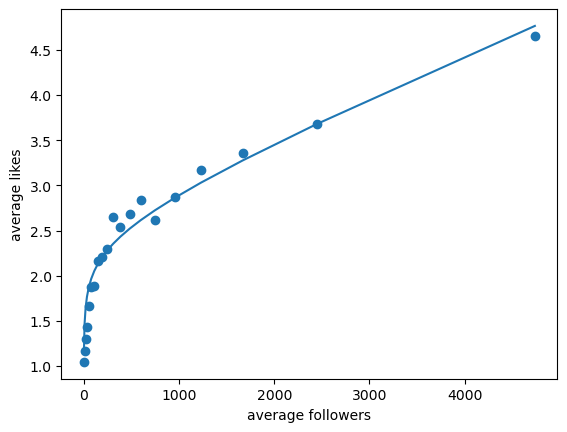

In [125]:
#TODO tune
q_order = 0.95 #quantile order
num_groups = 20 #number of groups

#remove outliers from data to plot
q = df.quantile(q_order, numeric_only=True) #numeric_only to fix warning
df_q = df[(df['likes'] < q['likes']) & (df['followers'] < q['followers'])].copy() #copy to fix warning

#group by followers
df_q.sort_values(by='followers', inplace=True, ignore_index=True)
df_q['group'] = df_q.index//(len(df_q)/num_groups) #groups of same size
df_q = df_q.groupby('group').mean(numeric_only=True) #numeric_only to fix warning

#plot average likes vs average followers
x = df_q['followers']
y = df_q['likes']
plt.scatter(x, y)
plt.xlabel('average followers')
plt.ylabel('average likes')

#fit curve and plot it
def curve(x, a, b):
    return 1 + a*x + b*np.log(1+x)
(a, b), _ = curve_fit(curve, xdata=x, ydata=y)
plt.plot(x, curve(x, a, b))
a, b

In [126]:
#TODO tune
lower = 0.5 #lower bound for medium popularity
upper = 1.5 #upper bound for medium popularity

#get popularity by normalizing likes
df['popularity'] = df['likes']/curve(df['followers'], a, b) #likes starts from 1
df['pop_level'] = df['popularity'].apply(lambda x: 0 if x<lower else 1 if x<upper else 2)

#prevent a low pop tweet with 0 likes from being labeled as medium pop if it hasn't enough followers
df_pop = df[(df['likes']>1) | (1/curve(df['followers'], a, b)<lower)].reset_index().copy()

#save tweets with popularity
df_pop['likes'] -= 1 #set likes back to the original values
df_pop.to_csv(dir_+'dataset_pop.csv', index=False)

In [127]:
df_pop

,index,text,likes,followers,popularity,pop_level
0,0,i feel so shitty about my body today I want to...,1.0,343.0,0.836478,1
1,4,i want you to make yourself your lunch and let...,3.0,277.0,1.725492,2
2,6,..Wanna go get some lunch?,0.0,329.0,0.420820,0
3,9,hello! not new to edtwt (switched accs) + look...,4.0,14.0,3.154363,2
4,10,20-30 min wait to get a dosa at avrebele mela ...,0.0,98.0,0.494204,0
...,...,...,...,...,...,...
13496,17209,Vanilla hulk from smoothie king never disappoints,1.0,243.0,0.878640,1
13497,17210,Finally going to eat my instant ramen.....I wa...,1.0,79.0,1.015212,1
13498,17211,Been up since 7 am everyone else still sleep…....,0.0,371.0,0.413348,0
13499,17212,NOOOOOO I meant to buy a six pack of diet soda...,1.0,131.0,0.953010,1
